In [1]:
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import torch

In [2]:
PROJECT_DIR = Path.cwd().parent
sys.path.append(str(PROJECT_DIR))

In [3]:
from src.utils.dirutils import get_data_dir, get_models_dir
from src.models.multiclassification.evaluate_model import evaluate
from datasets import load_from_disk

/home/nico/Thesis/neural-artwork-caption-generator/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
DATA_DIR = get_data_dir()
MODELS_DIR = get_models_dir()
MULTICLASSIFICATION_MODEL_DIR = MODELS_DIR / "multiclassification"
TRAIN_VIZ_DIR = MULTICLASSIFICATION_MODEL_DIR / "train_viz"

In [5]:
features = ("artist", "genre", "style", "media", "tags")

In [6]:
def loss_viz():
    train = {}
    val = {}

    for feature in features:
        # read and concat every csv file
        train[feature] = []
        viz_dir = TRAIN_VIZ_DIR / f"{feature}_loss"
        for csv_file in sorted(os.listdir(viz_dir)):
            train[feature] += list(pd.read_csv(viz_dir / csv_file)["Value"].values)
        val[feature] = []
        viz_dir = TRAIN_VIZ_DIR / f"v{feature}_loss"
        for csv_file in sorted(os.listdir(viz_dir)):
            val[feature] += list(pd.read_csv(viz_dir / csv_file)["Value"].values)

    # plot val and train loss for each feature
    fig, axs = plt.subplots(5, 1, figsize=(10, 20))
    for i, feature in enumerate(features):
        # Generate x-axis values starting from 1
        x_train = np.arange(1, len(train[feature]) + 1)
        x_val = np.arange(1, len(val[feature]) + 1)

        axs[i].plot(x_train, train[feature], label="train")
        axs[i].plot(x_val, val[feature], label="val")
        axs[i].set_title(feature)
        axs[i].legend()

    plt.tight_layout()
    plt.savefig("loss_plot.png", dpi=300)

In [7]:
def macro_f1_viz():
    val = {}

    for feature in features + ("avg",):
        # read and concat every csv file
        val[feature] = []
        viz_dir = TRAIN_VIZ_DIR / f"v{feature}_macro_f1"
        for csv_file in sorted(os.listdir(viz_dir)):
            val[feature] += list(pd.read_csv(viz_dir / csv_file)["Value"].values)

    # plot val and train loss for each feature
    # plot val and train loss for each feature
    fig, axs = plt.subplots(6, 1, figsize=(10, 20))
    for i, feature in enumerate(features + ("avg",)):
        # Generate x-axis values starting from 1
        x_val = np.arange(1, len(val[feature]) + 1)

        axs[i].plot(x_val, val[feature], color="red", label="val")
        axs[i].set_title(feature)
        axs[i].legend()

    plt.tight_layout()
    plt.savefig("f1_plot.png", dpi=300)

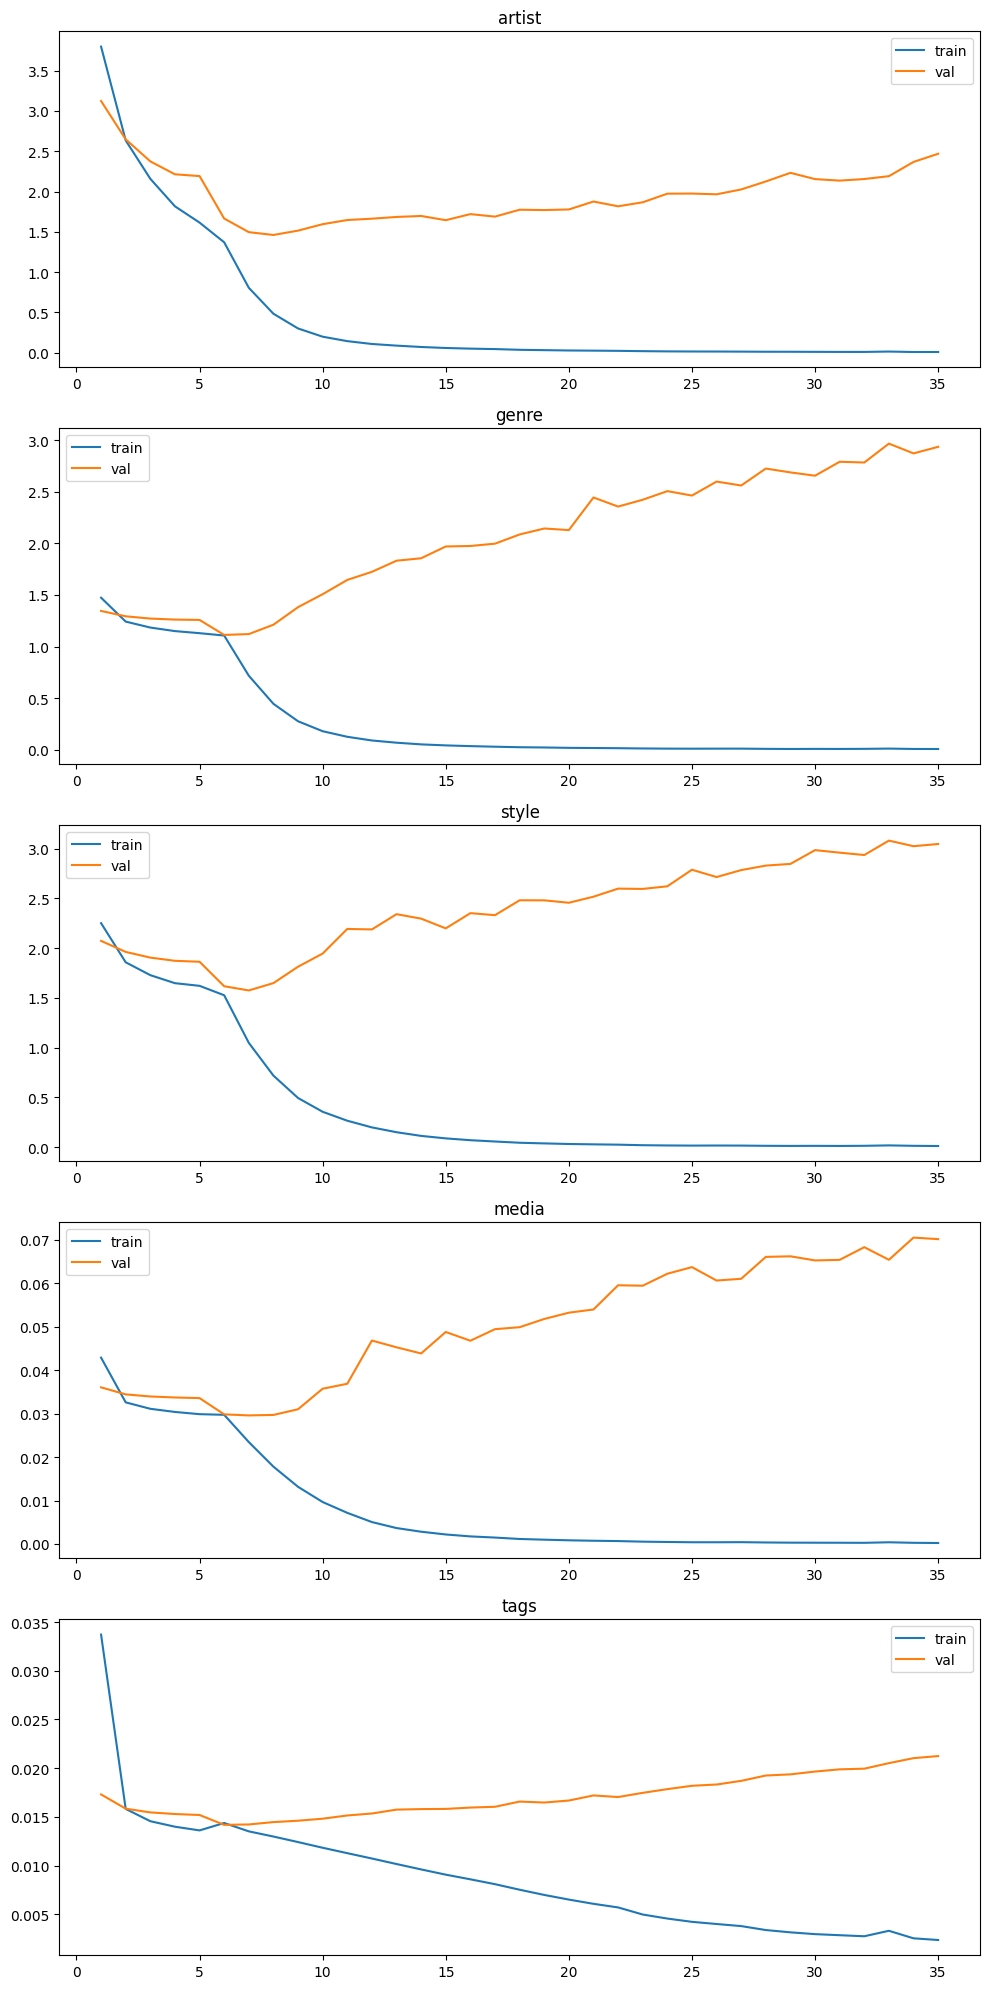

In [8]:
loss_viz()

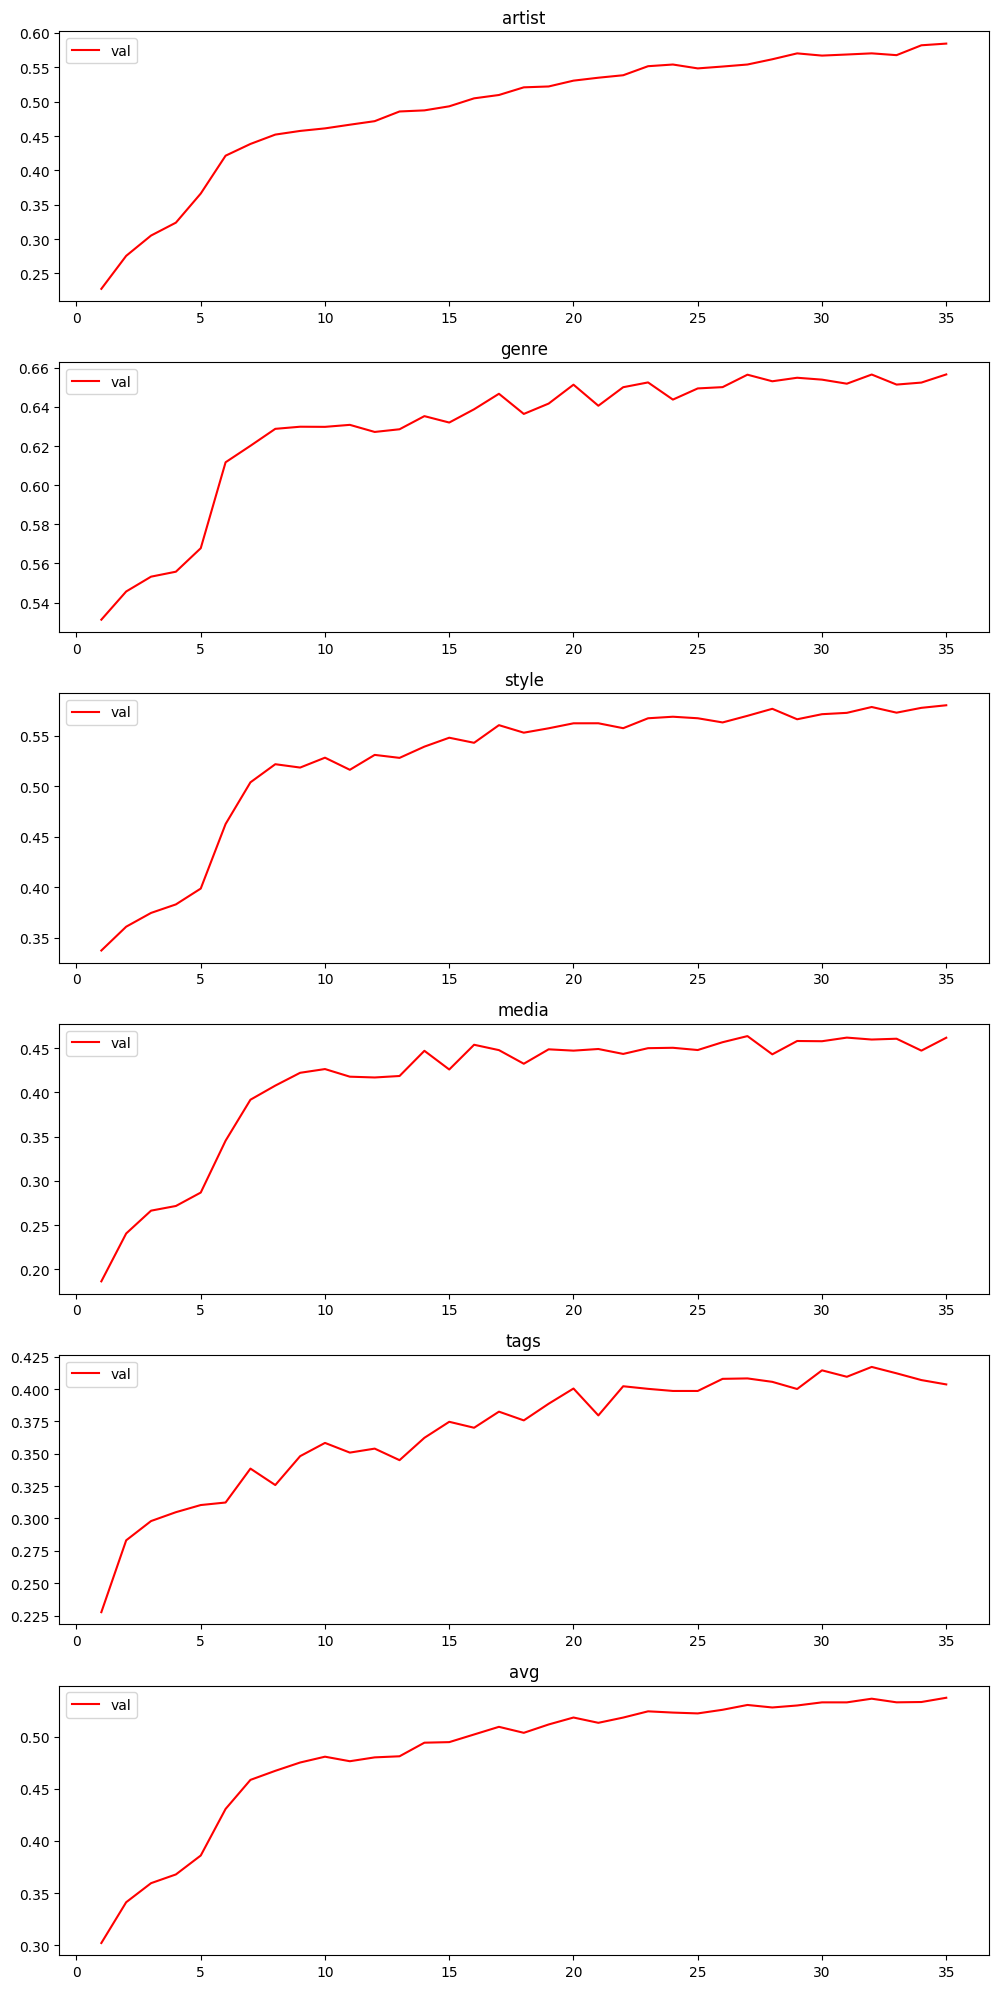

In [9]:
macro_f1_viz()

In [10]:
avg_macro_f1 = []
for csv_file in sorted(os.listdir(TRAIN_VIZ_DIR / "vavg_macro_f1")):
    avg_macro_f1 += list(pd.read_csv(TRAIN_VIZ_DIR / "vavg_macro_f1" / csv_file)["Value"].values)

print(f"The best result of validation avg macro f1 is at the {np.argmax(avg_macro_f1) + 1}th epoch.")
print(f"With a score of {np.max(avg_macro_f1)}.")

The best result of validation avg macro f1 is at the 35th epoch.
With a score of 0.5373549461364746.


In [ ]:
# load the best model
from src.models.multiclassification.model import ViTForMultiClassification
from functools import partial
from src.models.multiclassification.data import get_multiclassification_dicts, compute_class_weight_tensors, transform_for_model

model = ViTForMultiClassification(*get_multiclassification_dicts())
model.to("cuda")

In [ ]:
model.load_state_dict(torch.load(MULTICLASSIFICATION_MODEL_DIR / "full" / "model-20230513_121917-35.pt")["model_state_dict"])
model.train(False)
from transformers import ViTImageProcessor
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

In [ ]:
dataset = load_from_disk(DATA_DIR / "processed" / "multiclassification_dataset")
class_weight_tensors = compute_class_weight_tensors(dataset, "cuda")
dataset = dataset.with_transform(partial(transform_for_model, processor=processor, device="cuda"))

In [ ]:
test_dataloader = torch.utils.data.DataLoader(
    dataset["test"],
    batch_size=8,
)

In [ ]:
results = evaluate(
    model,
    test_dataloader,
    class_weight_tensors,
    *[list(d.keys()) for d in get_multiclassification_dicts()],
    8,
    32//8
)

In [ ]:
results